$$
\newcommand{\EE}{\mathbb{E}}
\newcommand{\wb}{\mathbf{w}}
\newcommand{\zb}{\mathbf{z}}
\newcommand{\Poisson}{\text{Poisson}}
\newcommand{\Dir}{\text{Dir}}
\newcommand{\Multinomial}{\text{Multinomial}}
$$

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

In [176]:
sns.set_style("ticks")
sns.set_context("talk", font_scale=2, rc={"lines.linewidth": 2})

![LDA Authors](LDA/LDA_Authors.png "LDA Authors")

<sup>* Picture are reproduced from [original paper](http://jmlr.csail.mit.edu/papers/v3/blei03a.html)</sup>

+ A **word** is the basic unit of discrete data, defined to be an item from a vocabulary indexed by $\{1,...,V\}$.

+ A **document** is a sequence of N words denoted by $\wb = (w_1,w_2,...,w_N)$, where $w_n$ is the nth word in the sequence.

+ A **corpus** is a collection of M documents denoted by $D = \{w_1,w_2,...,w_M\}$.

> We wish to find a probabilistic model of a corpus that not only assigns high probability to
members of the corpus, but also assigns high probability to other “similar” documents.

## Latent Dirichlet Allocation

1. Choose $N \sim \Poisson(\zeta)$.
2. Choose $\theta \sim \Dir(\alpha)$.
3. For each of the $N$ words $w_n$:

  (a) Choose a topic $z_n \sim \Multinomial(\theta)$.
  
  (b) Choose a word $w_n$ from $p(w_n \vert z_n,\beta)$, a multinomial probability conditioned on the topic $z_n$.

![LDA Graphical Model](LDA/LDA_graph.png "LDA GRaphical Model")

In [179]:
W = 200
D = 200
D_test = 160
K = 4
N = 50
alpha = np.array(np.linspace(0.2, 1, 4))
beta = np.random.uniform(size=(N, K)).T
beta = beta / beta.sum(axis=1)[:, np.newaxis]
data = []
topics = []
data_test = []
topics_test = []
for d in range(D):
    d__ = []
    theta = np.random.dirichlet(alpha, 1)[0]

    for w in range(W):
        z = np.random.multinomial(n=1, pvals=theta, size=1)
        z_ = z.astype(bool)[0]
        rand_ = np.random.uniform()
        d__.append((rand_ > np.cumsum(beta[z_, :])).sum())
    if d > D_test:
        data_test.append(d__)
        topics_test.append(theta)
    else:
        data.append(d__)
        topics.append(theta)
topics = np.array(topics)
data = np.array(data)

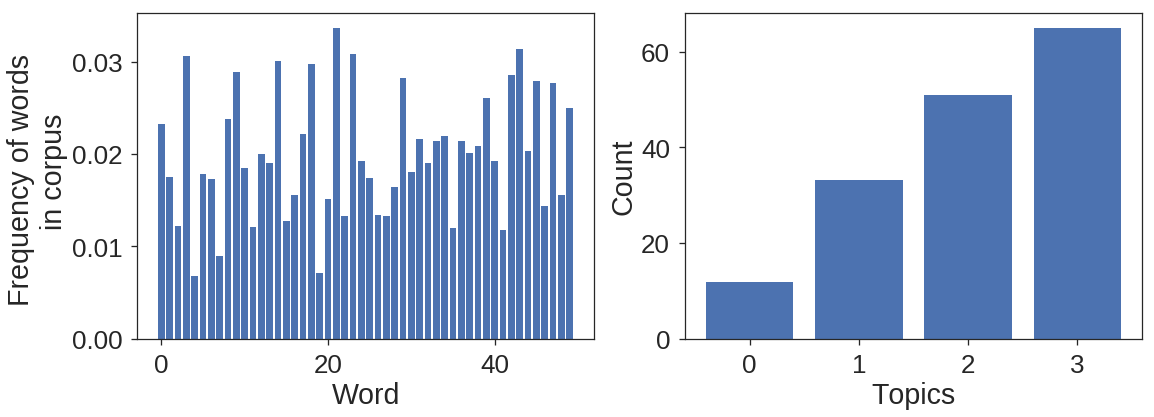

In [180]:
plt.figure(figsize=(6 * 3, 6))
plt.subplot(1, 2, 1)
vals, counts = np.unique(data, return_counts=True)
plt.bar(vals, counts / counts.sum())
plt.xlabel("Word")
_ = plt.ylabel("Frequency of words \n in corpus")
plt.subplot(1, 2, 2)
plt.bar(np.arange(topics.shape[1]), topics.sum(axis=0))
plt.xlabel("Topics")
plt.xticks(np.arange(topics.shape[1]))
_ = plt.ylabel("Count")

### Likelihood function

Given parameters $\alpha$ and $\beta$, the joint distribution of a topic mixture $\mathbf{\theta}$, a set of $N$ topics $\mathbf{z}$, and a set of $N$ words $\mathbf{w}$ is given by:

\begin{align}
p(\mathbf{\theta},\mathbf{z},\mathbf{w}\vert \alpha,\beta)=p(\mathbf{\theta}\vert \alpha)\prod_{n=1}^{N}p(z_n\vert \mathbf{\theta})p(w_n\vert z_n,\beta)
\end{align}


We only observe $\wb$ while $\theta$ and $\zb$ are not observed. Integrating over $\mathbf{\theta}$ and summing over $z$, we get marginal probabilities of a document:


\begin{align}
p(\mathbf{w}\vert \alpha,\beta)=\int p(\mathbf{\theta}\vert \alpha)\big(\prod_{n=1}^{N}\sum_{z_{dn}}p(z_n\vert \mathbf{\theta})p(w_n\vert z_n,\beta)\big)d\theta
\end{align}

Finally the likelihood of observing a corpus is:

\begin{align}
p(D\vert \alpha,\beta)=\prod_{d=1}^{M}\int p(\mathbf{\theta}_d\vert \alpha)\big(\prod_{n=1}^{N}\sum_{z_{dn}}p(z_n\vert \mathbf{\theta}_d)p(w_n\vert z_n,\beta)\big)d\theta_d
\end{align}


----

## Inference

We take a Bayesian perspective, and are interested in posterior distribtion
after observing data.

for a given document we have:

\begin{align}
p(\mathbf{\theta},\mathbf{z}\vert \mathbf{w},\alpha,\beta) = \frac{p(\mathbf{\theta},\mathbf{z},\mathbf{w}|\alpha,\beta)}{p(\mathbf{w}\vert \alpha,\beta)}
\end{align}

Normalization constant in this distribution is intractable, therefore, we try other methods such as **Variational Inference**, *Sampling* or *Approxiamtion*.

### Variational Inference

> The basic idea of convexity-based variational inference is to make use of Jensen’s inequality to obtain
an adjustable lower bound on the log likelihood (Jordan et al., 1999). Essentially, one considers
a family of lower bounds, indexed by a set of variational parameters. The variational parameters
are chosen by an optimization procedure that attempts to find the tightest possible lower bound.

Take a prticular family of variational distributions:
\begin{align}
q(\mathbf{\theta},\mathbf{z}|\gamma,\phi) = q(\theta|\gamma)\prod_{n=1}^{N} q(z_n|\mathbf{\phi}_n)
\end{align}

![alt text](LDA/LDA_variational.png "LDA Graphical Model, variational inference.")

Set up an optimization problem that determines the values of the variational parameters $\gamma$ and $\phi$:

\begin{align}
(\gamma^{*},\phi^{*}) = \text{argmin}_{(\gamma,\phi)} 
\text{D}\big[q(\mathbf{\theta},\mathbf{z}|\gamma,\phi) ||p(\mathbf{\theta},\mathbf{z}|\mathbf{w},\alpha,\beta)\big].
\end{align}

Which results in following pair of update rules:

\begin{align}
\phi_{ni} \propto \beta_{iv} \exp{(\Psi(\gamma_i)-\Psi(\sum_{j=1}^{k}\gamma_i))}.
\end{align}

\begin{align}
\gamma_{i} = \alpha_i+\sum_{n=1}^{N} \phi_{ni}
\end{align}

#### Derivation
\begin{align}
p(\mathbf{\theta},\mathbf{z},\mathbf{w}|\alpha,\beta)=p(\mathbf{\theta}|\alpha)\prod_{n=1}^{N}p(z_n|\mathbf{\theta})p(w_n|z_n,\beta)
\end{align}

\begin{align}
\log{p(\mathbf{w}|\alpha,\beta}) =~& \log{\int \sum_{\mathbf{z}} p(\theta,\mathbf{z},\mathbf{w}|\alpha,\beta)}d\theta\nonumber\\
=~&\log{\int \sum_{\mathbf{z}}\frac{ p(\theta,\mathbf{z},\mathbf{w}|\alpha,\beta)q(\theta,\mathbf{z})}{q(\theta,\mathbf{z})}}d\theta\nonumber\\
\geq~&\int \sum_{\mathbf{z}} q(\theta,\mathbf{z})\log{p(\theta,\mathbf{z},\mathbf{w}|\alpha,\beta)}-q(\theta,\mathbf{z})\log{q(\theta,\mathbf{z}})d\theta\tag*{Jensen's inequality}\\
=~& \EE_q[{\log{p(\theta,\zb,\wb|\alpha,\beta})}]-\EE_q[\log{q(\theta,\zb)}] = L (\gamma,\phi;\alpha,\beta)
\end{align}

\begin{align}
L(\gamma,\phi;\alpha,\beta) = \EE_q[\log{p(\theta|\alpha)}]+ \EE_q[\log{p(\zb|\theta)}]+\EE_q[\log{p(\wb|\zb,\beta)}]- \EE_q[\log{q(\theta)}] - \EE_q[\log{q(\zb)}] 
\end{align}

\begin{align}
L(\gamma,\phi;\alpha,\beta) &~= \log{\Gamma(\sum_{j=1}^k \alpha_j)} - \sum_{i=1}^k \log{\Gamma(\alpha_i)} + \sum_{i=1}^k (\alpha_i - 1)\big(\Psi(\gamma_i)-\Psi(\sum_{j=1}^k \gamma_j)\big)\\
&~+ \sum_{n=1}^N \sum_{i=1}^k \phi_{ni}\big(\Psi(\gamma_i) - \Psi(\sum_{j=1}^k \gamma_j)\big)\\
&~+ \sum_{n=1}^N \sum_{i=1}^k \phi_{ni}w_n^j \log{\beta_{ij}}\\
&~- \log{\Gamma(\sum_{j=1}^k \gamma_j)} + \sum_{i=1}^k \log{\Gamma(\gamma_i)} - \sum_{i=1}^k (\gamma_i - 1)(\Psi(\gamma_i)-\Psi(\sum_{j=1}^k \gamma_j))\\
&~- \sum_{n=1}^N \sum_{i=1}^k \phi_{ni}\log{\phi_{ni}}
\end{align}

Maximizing the above equation wrt to each parameter:

\begin{align}
L_{[\phi_{ni}]} =~&  \phi_{ni}(\Psi(\gamma_i)-\Psi(\sum_{j=1}^{k}\gamma_i) + \phi_{ni}\log{\beta_{iv}} - \phi_{ni}\log(\phi_{ni}) + \lambda_n(\sum_{j=1}^{k} \phi_{nj} -1)\\
\frac{\partial L_{[\phi_{ni}]}}{\partial \phi_{ni}} =~&  \Psi(\gamma_i)-\Psi(\sum_{j=1}^{k}\gamma_i) + \log{\beta_{iv}} - \log(\phi_{ni}) -1 + \lambda\\
\phi_{ni} \propto~&  \beta_{iv} \exp{(\Psi(\gamma_i)-\Psi(\sum_{j=1}^{k}\gamma_i))}.
\end{align}

---

\begin{align}
L_{[\gamma_{i}]} =~& \sum_{i=1}^{k}(\alpha_i - 1)(\Psi(\gamma_i)-\Psi(\sum_{j=1}^{k}\gamma_j)) + \sum_{n=1}^{N} \phi_{ni}(\Psi(\gamma_i) - \Psi(\sum_{j=1}^{k}\gamma_j))\\
%
&-\log{\Gamma(\sum_{j=1}^{k}\gamma_j)}+\log{\Gamma(\gamma_i)-\sum_{i=1}^{k}(\gamma_i-1)(\Psi(\gamma_i)-\Psi(\sum_{j=1}^{k}\gamma_j))}\\
%%
=~& \sum_{i=1}^{k}(\Psi(\gamma_i)-\Psi(\sum_{j=1}^{k}\gamma_j)(\alpha_i + \sum_{n=1}^{N}\phi_{ni}-\gamma_{i})-\log{\Gamma(\sum_{j=1}^{k}\gamma_j)}+\log{\Gamma(\gamma_i)}\\
%
\frac{\partial L_{[\gamma_{i}]}}{\partial\gamma_{i}} =~& \Psi'(\gamma_i)(\alpha_i + \sum_{n=1}^{N}\phi_{ni}-\gamma_{i})-\Psi'(\sum_{j=1}^{k}\gamma_j)\sum_{j=1}^{k}(\alpha_j + \sum_{n=1}^{N}\phi_{nj}-\gamma_{j})\\
\gamma_{i} =~& \alpha_i+\sum_{n=1}^{N} \phi_{ni}
\end{align}

## Experiments

In [47]:
alpha0 = np.ones(K)
phi = np.zeros((data.shape[0], data.shape[1], K))
phi[:, :, :] = 1 / K
gamma = np.zeros((data.shape[0], K))
gamma[:, :] = alpha + phi.shape[0] / K
beta0 = np.random.uniform(size=(K, N))
beta0 = beta / beta.sum(axis=1)[:, np.newaxis]

In [167]:
def L(phi, gamma, beta0, alpha0):
    temp = 0
    for m in range(phi.shape[0]):
        ss = sp.special.digamma(gamma[m, :]) -\
             sp.special.digamma(gamma[m, :].sum())

        temp = sp.special.loggamma(
            alpha0.sum()) - sp.special.loggamma(alpha0).sum() + ((alpha0 - 1) * ss).sum()

        temp += (phi[m, :, :] * ss).sum()

        temp += (phi[m, :, :] * beta0[:, data[m, :]].T).sum()

        temp += -sp.special.loggamma(gamma[m, :].sum()) + sp.special.loggamma(
            gamma[m, :]).sum() - ((gamma[m, :] - 1) * ss).sum()

        temp += (-phi[m, :, :] * np.log(phi[m, :, :])).sum()

    return np.real(temp)


def update_vi(phi, gamma, beta0, alpha0):
    m = 0
    history = []
    iter_ = 0
    beta = beta0.copy()
    while(True):
        phi_temp = phi.copy()
        gamma_temp = gamma.copy()
        for m in range(phi.shape[0]):
            for n in range(phi.shape[1]):
                for i in range(gamma.shape[1]):
                    phi_temp[m, n, i] = beta[i, data[m, n]] * np.exp(sp.special.digamma(gamma[m, i]) -\
                                                                     sp.special.digamma(gamma[m, :].sum()))

            phi_temp[m, :, :] = phi_temp[m, :, :] /\
                                phi_temp[m, :, :].sum(axis=1)[:, np.newaxis]
        for m in range(gamma.shape[0]):
            for i in range(gamma.shape[1]):
                gamma_temp[m, i] = alpha0[i] + phi_temp[m, :, i].sum()

        diff_gamma = np.mean((gamma_temp - gamma)**2)
        diff_phi = np.mean((phi_temp - phi)**2)

        if ((diff_phi < 1e-3) & (diff_gamma < 1e-3)):
            break

        phi = phi_temp
        gamma = gamma_temp
                
        L_ = L(phi, gamma, beta, alpha0)
        
        print("diff gamma %f" % diff_gamma, "diff phi %f" %
              diff_phi, "L %f" % L_)
        history.append((beta, phi, gamma, L_))
        iter_ += 1
    return phi, gamma, beta, iter_, history

In [168]:
new_phi, new_gamma, new_beta, iter_, history = update_vi(
    phi, gamma, beta0, alpha0)

diff_gamma = np.mean(np.abs(new_gamma - gamma))
diff_phi = np.mean(np.abs(new_phi - phi))
diff_beta = np.mean(np.abs(new_beta - beta))
print("iter", iter_)
print("diff gamma %f" % diff_gamma, "diff phi %f" % diff_phi)
print("diff beta %f" % diff_beta)

diff gamma 133.635209 diff phi 0.014895 L -23.776968
diff gamma 25.256380 diff phi 0.000735 L -23.141265
diff gamma 22.212411 diff phi 0.000636 L -22.511695
diff gamma 18.884462 diff phi 0.000534 L -21.896922
diff gamma 15.560183 diff phi 0.000436 L -21.305556
diff gamma 12.495897 diff phi 0.000349 L -20.745106
diff gamma 9.842222 diff phi 0.000274 L -20.221272
diff gamma 7.646850 diff phi 0.000213 L -19.737676
diff gamma 5.888301 diff phi 0.000164 L -19.295954
diff gamma 4.510381 diff phi 0.000126 L -18.896069
diff gamma 3.446265 diff phi 0.000097 L -18.536718
diff gamma 2.631902 diff phi 0.000074 L -18.215718
diff gamma 2.011879 diff phi 0.000057 L -17.930349
diff gamma 1.540939 diff phi 0.000044 L -17.677624
diff gamma 1.183386 diff phi 0.000034 L -17.454480
diff gamma 0.911664 diff phi 0.000026 L -17.257917
diff gamma 0.704776 diff phi 0.000020 L -17.085083
diff gamma 0.546850 diff phi 0.000016 L -16.933323
diff gamma 0.425937 diff phi 0.000012 L -16.800206
diff gamma 0.333056 diff

In [169]:
vals = []
val_name = []
val_exp = []
val_unit = []
for ind, h in enumerate(history):
    t = np.abs(h[2] / h[2].sum(axis=1)[:, np.newaxis] - topics)
    vals.extend(t.flatten().tolist())
    val_name.extend(['$\\bar{\\gamma}-\\theta$'] * t.shape[0] * t.shape[1])
    val_exp.extend([ind] * t.shape[0] * t.shape[1])
    val_unit.extend(np.arange(t.shape[0] * t.shape[1]))

    l = np.exp(h[3])
    vals.extend([l])
    val_name.extend(['$L$'])
    val_exp.extend([ind])
    val_unit.extend([0])

In [170]:
import pandas as pd

df = pd.DataFrame(data={"vals": vals, "param": val_name,
                        "exp": val_exp, "unit": val_unit})

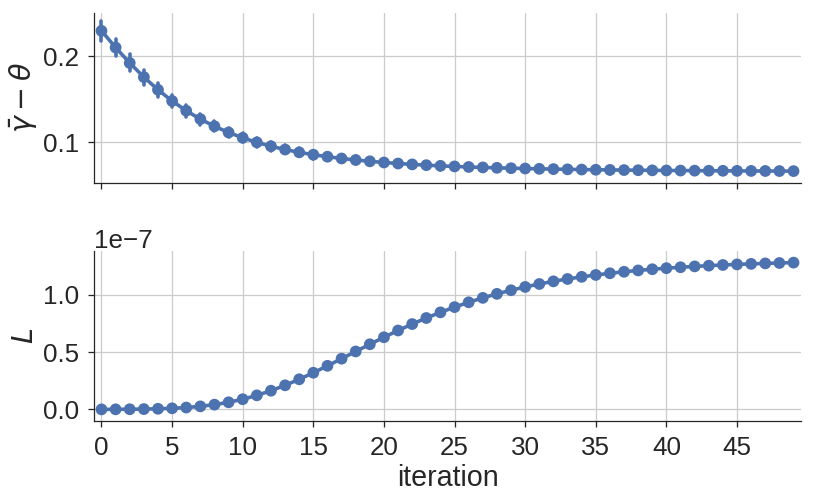

In [177]:
g = sns.factorplot(data=df, x="exp", y="vals",
                   row="param", sharey=False, aspect=3).set_titles("{row_name}")
g.axes[0, 0].set_ylabel(g.axes[0, 0].get_title())
g.axes[1, 0].set_ylabel(g.axes[1, 0].get_title())
g.axes[0, 0].set_title("")
g.axes[1, 0].set_title("")
g.axes[1, 0].grid("on")
g.axes[0, 0].grid("on")
g.axes[0, 0].set_xticks(np.arange(0, len(history), 5))
g.axes[0, 0].set_xticklabels(np.arange(0, len(history), 5))
plt.xlabel("iteration")